<a href="https://colab.research.google.com/github/wenjunsun/personal-machine-learning-projects/blob/master/customer_churn_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Data Source](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers): from Kaggle. Mainly toy data, no description, no objective metrics, no explanation of how data was collected or what that data means specifically. It is about the task of giving the features of customers, predict whether he will churn or not (whether he will leave the bank)

##Download data from google drive shared link url and load it into variable df

Could also use PyDrive or Mount Google Drive but this method is simper

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# one way to read data, directly from the csv download link from google drive.
# I think this is the easiest way, but of course there are other ways like mounting the drive, etc.
file_id = '1yDcwAMmyeznHD2mZC4CYKqdoRhVZySPO'
link=f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(link)

## Look at Data (size of data set, what are the features, any null values?)

In [0]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
df.shape

(10000, 14)

In [0]:
df['Exited'].mean() # 20% of churned customers

0.2037

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


* With 10000 rows this is rather a small data set  
* need to get rid of rowNumber and Id and Surname in analysis because they don't provide information
*   hasCard, IsActiveMember, Gender, Geography are all categorical, need to deal with it later.
*   This is a supervised binary classification problem
  * we can try things like SVM, KNN, RF, logistic regression, etc as base model.
* There is no missing/null value so we don't need to worry about it.


##Data exploration/cleaning

In [0]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
# let's get rid of columns we don't want
df.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1,inplace=True)

In [0]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


let's look at distribution of salary data.

In [0]:
df['EstimatedSalary'].describe()['mean']

100090.2398809998

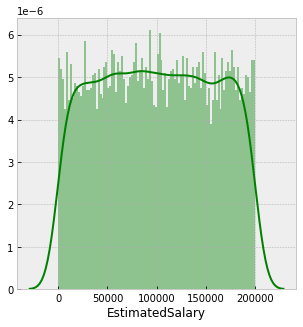

In [0]:
plt.style.use('bmh')
plt.figure(figsize=(5, 5))
sns.distplot(df['EstimatedSalary'], color='g', bins = 100, hist_kws={'alpha': 0.4})

we can see from the plot that the distirbution of salary is pretty uniform and there is no major outliers.

now let's look at all numerical variable's distribution

In [0]:
list(set(df.dtypes.to_list())) # to see what data types are there.

[dtype('O'), dtype('int64'), dtype('float64')]

In [0]:
df_numerical = df.select_dtypes(include=['float64','int64'])

In [0]:
df_numerical.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


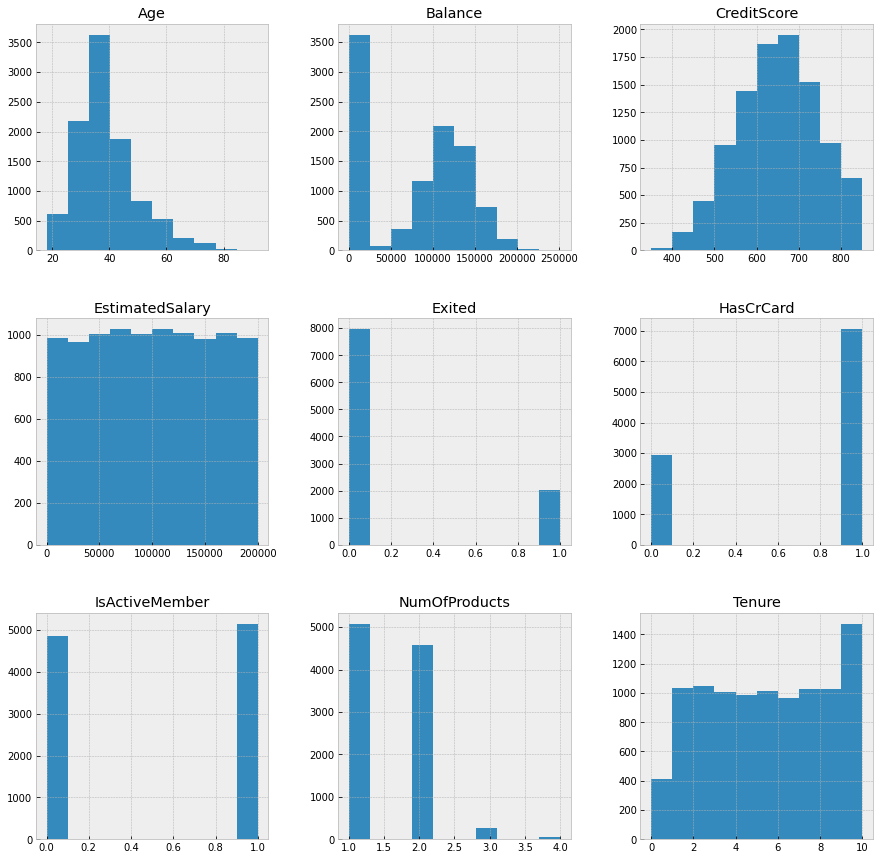

In [0]:
df_numerical.hist(figsize=(15,15));

*   credit score/age is about a normal distribution, which is what we expect.
*   tenure distribution is skewed a little. 1400+ people have stayed about 10 years with our bank! That is a long time. Are they more likely to churn or less likely? we will find out. (There are 400 people who just joined our bank with 0-1 year of tenure) (assuming here tenure means the time the customer has stayed in the bank, and the unit is in years. The data source really doesn't tell us anything about it, so I am assuming here)
* **There are many people with just a little balance in the account. That is interesting - maybe they are the ones who will leave the bank? - business insight**




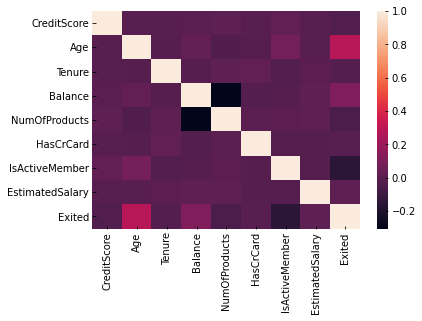

In [0]:
# we will explore linear correlations between numerical features.
# why? - because some models don't work well with correlated features,
# such as linear models.
# note that 0 correlatoin != independence.
sns.heatmap(df_numerical.corr());

In [0]:
df_numerical.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


we can see that age and IsActiveMember might have a strong impact on the churn probability of a customer. **Note: correlation only measures linear relationship and we cannot say for sure other variabels don't have strong impact!** 

In [0]:
corr = df.drop(columns=['Exited']).corr()

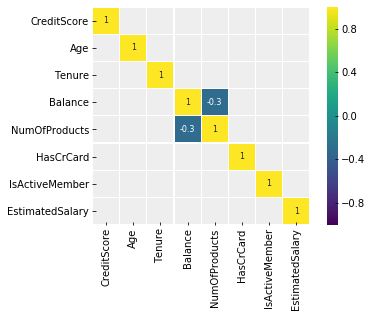

In [0]:
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


Some ML models require non-correlated features, but since this data set's features doesn't have strong correlations (all correlatoins <= 0.3) so we don't need to worry about that.

Now let's visualize the relationship between target variable and some numerical variables in another way with box-whisker plot (using seaborn)

In [0]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

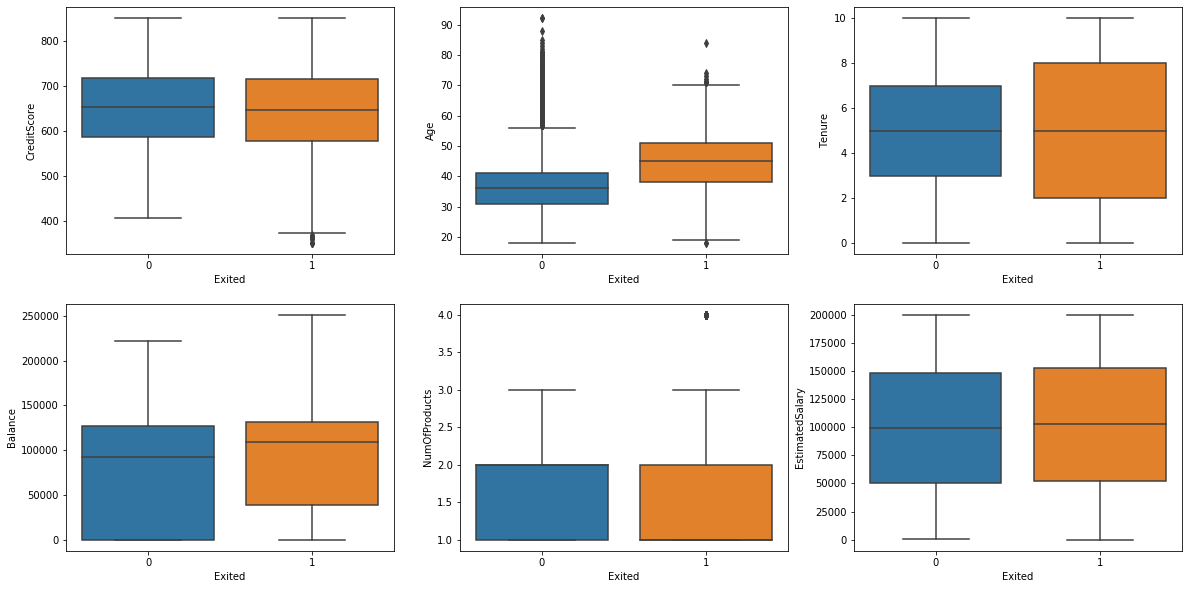

In [0]:
_ ,axes = plt.subplots(2, 3, figsize = (20,10))
sns.boxplot(x='Exited', y ='CreditScore', data=df,ax=axes[0][0])
sns.boxplot(x='Exited', y ='Age', data=df,ax=axes[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=df,ax=axes[0][2])
sns.boxplot(x='Exited', y ='Balance', data=df,ax=axes[1][0])
sns.boxplot(x='Exited', y ='NumOfProducts', data=df,ax=axes[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=df,ax=axes[1][2])

Notice that age distribution is a lot different for churned/non-churned customers! That will be worthwhile to investigate in the future

#Now let's look at categorical data!

In [0]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


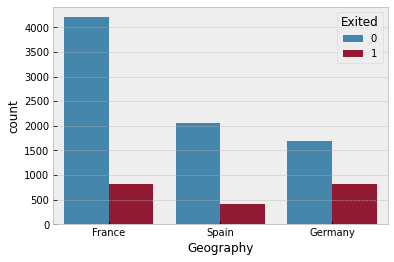

In [0]:
sns.countplot(data=df, hue='Exited', x = 'Geography')

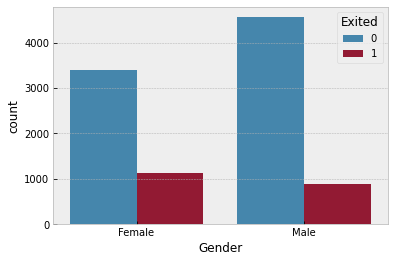

In [0]:
sns.countplot(data=df, hue='Exited', x= 'Gender')

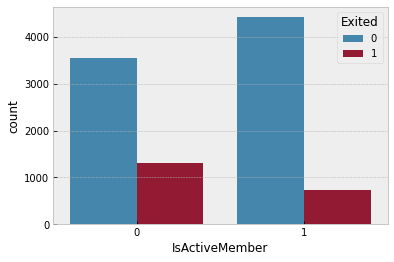

In [0]:
sns.countplot(data=df, hue='Exited', x= 'IsActiveMember')

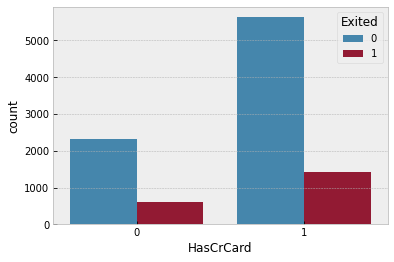

In [0]:
sns.countplot(data=df, hue='Exited', x= 'HasCrCard')

the relative frequencies of 0(didn't exit) and 1(exit) seems to be about the same across many different categorical vairbales. This means that maybe
the categorical variabels aren't gonna help us very much in terms of predicting
the target variable.

# Data preprocessing for models



Deal with categorical variables - one hot encoding(gender, geography, hasCrCard, IsActiveMember). I think one hot encoding does the job here since
we don't have many categories for each variable. (3 categories for geography, 2 categories for gender). If there are a lot of categoreis I will use other encoding methods.

In [0]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
y = df['Exited'] # target variable for prediction

In [0]:
df['Gender'] = df['Gender'] == 'Female' # replace Female by 1 and male by 0

In [0]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,True,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,True,41,1,83807.86,1,0,1,112542.58,0
2,502,France,True,42,8,159660.80,3,1,0,113931.57,1
3,699,France,True,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,True,43,2,125510.82,1,1,1,79084.10,0


In [0]:
df = pd.get_dummies(df, columns=['Geography'], drop_first = True)
# create two more columns for Geography column. - one hot encoding

In [0]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,True,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,True,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,True,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,True,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,True,43,2,125510.82,1,1,1,79084.10,0,0,1


In [0]:
X = df.drop(['Exited'], axis=1) # drop the target variable column to create feature matrix

In [0]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
0,619,True,42,2,0.00,1,1,1,101348.88,0,0
1,608,True,41,1,83807.86,1,0,1,112542.58,0,1
2,502,True,42,8,159660.80,3,1,0,113931.57,0,0
3,699,True,39,1,0.00,2,0,0,93826.63,0,0
4,850,True,43,2,125510.82,1,1,1,79084.10,0,1


In [0]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [0]:
len(X), len(y) # check the length matches.

(10000, 10000)

# Model Training and Result Evaluation

## Part1: split dataset

In [0]:
from sklearn import model_selection

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, stratify = y)

In [0]:
X_train.shape

(7500, 11)

In [0]:
X_test.shape

(2500, 11)

In [0]:
y_train.shape

(7500,)

In [0]:
y_test.shape

(2500,)

##Part 2. standardization

In [0]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
# same standardization must apply both to training and testing set

##Part 3. Base Model Training and Selection


1.   This is a binary classification problem, so SVM is probably the best off-the-shelf model. It utilizes the notion of distance. I will definitely try this model first. 
2.   logistic regression is used because we might want probabilistic interpretation of results. For example, for a customer with 0.9 probability of churning we might use more agressive strategy like giving him/her more credits or something, compared to a customer with 0.6 probability of churning.

  I know SVM also can also output probability, I don't know how it does that, but that is not honest probability in a mathematical sense.
  
  Draw back is logistic regression prones to overfit, so we need to tune regularization constant.
3.   Picked random forest because it is very powerful, not easy to overfit, and it usually has good results. Also has the benefit of gaining feature importance from this model.
4. K Nearest Neighbors is a simple model also, which I suspect is going to underperform with respect to random forest.

**Note**: This is a relatively simple data set with 10000 data points, and 10+ features, so I will not bother with complex models like XgBoost or neural net. Neural net is not desirable here because we want to not only know our customer will exit, but why is the case, so we can prevent it. And neural net is terrible at providing explainability

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

logisticClassifier = LogisticRegression()
KNNClassifier = KNeighborsClassifier()
RFClassifier = RandomForestClassifier()
svc = SVC()

In [0]:
# get 5-fold cross validation score of different models
model_names = ['SVC', 'Logistic Regression', 'Random Forest', 'KNN']
model_list =  [ svc, logisticClassifier, RFClassifier, KNNClassifier]



In [0]:
for index, model in enumerate(model_list):
  model_name = model_names[index]
  cv_score = model_selection.cross_val_score(model, X_train, y_train, cv = 5)
  print("scores of " + model_name + " are:", end = "")
  print(cv_score)
  print("mean cross validation accuracy of " + model_name + " is " + str(cv_score.mean()))
  print()

scores of SVC are:[0.85866667 0.85866667 0.85133333 0.84       0.86133333]
mean cross validation accuracy of SVC is 0.8539999999999999

scores of Logistic Regression are:[0.81       0.80733333 0.80666667 0.80333333 0.816     ]
mean cross validation accuracy of Logistic Regression is 0.8086666666666666

scores of Random Forest are:[0.864      0.868      0.858      0.83733333 0.86466667]
mean cross validation accuracy of Random Forest is 0.8583999999999999

scores of KNN are:[0.84266667 0.82733333 0.82266667 0.81666667 0.832     ]
mean cross validation accuracy of KNN is 0.8282666666666666



As we can see, SVM and random forest unsurprising did better than simple KNN or logistic regression. Next, we are going to fine tune hyperparameters for each model. Our model seems to not work so well - even if I guess all customers to not churn, without any information, I will get 0.8 accuracy, since there are 20% who churned.

## Part 4: finding optimal hyperparameters of each model using Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV

possible parameters for logistic regression: 
1. $l_1$ or $l_2$ penalty - LASSO or ridge
2. C is the inverse of regularization strength $\frac{1}{\lambda}$ 

In [0]:
# linear regression Grid Search
parameters = {
    'penalty':('l1','l2', 'elasticnet'),
    'C':(0.01, 0.05, 0.1, 0.2 ,1.5,10,25)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv = 5)
Grid_LR.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 1.5, 10, 25),
                         'penalty': ('l1', 'l2', 'elasticnet')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
Grid_LR.best_score_

0.8097333333333333

In [0]:
Grid_LR.best_params_ 
# seems like our best model requires pretty strong regularization - C is inverse of regularization strength.

{'C': 0.05, 'penalty': 'l1'}

In [0]:
best_LR_model = Grid_LR.best_estimator_

In [0]:
# KNN grid search
parameters = {
    'n_neighbors': [3,5,7,9,11],
    'p': [1,2,3], # p is the l_p norm metric choice, 2 is euclidean
    'weights':['uniform','distance']
}

In [0]:
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv = 5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
Grid_KNN.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

In [0]:
Grid_KNN.best_score_

0.8361333333333333

In [0]:
best_KNN_model = Grid_KNN.best_estimator_

In [0]:
# RF Grid Search
parameters = {
    'n_estimators' : [40,60,80,100,200],
    'criterion': ['gini', 'entropy']
}
Grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv = 5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
Grid_RF.best_params_

{'criterion': 'entropy', 'n_estimators': 40}

In [0]:
Grid_RF.best_score_

0.8620000000000001

In [0]:
best_RF_model = Grid_RF.best_estimator_

In [0]:
# SVM Grid Search
parameters = {
    'kernel':('rbf', 'poly'),
    'degree':(3, 5, 10), # degree of polynomial
    'gamma':('scale', 0.01, 0.1), # Kernel coefficient
    'C':(0.01, 0.1, 1, 5),
    'probability':[True] # want to plot it on ROC later, so turn this on.
}
Grid_SVM = GridSearchCV(SVC(),parameters, cv = 5) # this takes a long time - 25 minutes
Grid_SVM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.01, 0.1, 1, 5), 'degree': (3, 5, 10),
                         'gamma': ('scale', 0.01, 0.1),
                         'kernel': ('rbf', 'poly'), 'probability': [True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
Grid_SVM.best_params_

{'C': 5, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

In [0]:
Grid_SVM.best_score_

0.8554666666666666

In [0]:
best_SVM_model = Grid_SVM.best_estimator_

# Model Evaluation

Our exact evaluation metric will depend on our boss's opinion, but I think in this scenario, we need to maximize recall, since we really care about finding all the people who are gonna churn, so we can keep them here by some strategies. Yes we are going to predict people are actually not churning to churn, that is just gonna cost us some money to make them happier, but the other case of missing a person who will churn will definitely cost more profit in the long run.

other possible metrics include: accuracy, F1, precision, AUC

## best Model with AUC - Random Forest

In [0]:
from sklearn import metrics

In [0]:
confusion_matrix(y_test, best_RF_model.predict(X_test))

array([[1924,   67],
       [ 265,  244]])

In [0]:
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, trp_rf, _ = roc_curve(y_test, y_pred_rf)

In [0]:
y_pred_rf

array([0.2  , 0.15 , 0.8  , ..., 0.025, 0.2  , 0.05 ])

In [0]:
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, trp_lr, _ = roc_curve(y_test, y_pred_lr)

In [0]:
y_pred_knn = best_KNN_model.predict_proba(X_test)[:, 1]
fpr_knn, trp_knn, _ = roc_curve(y_test, y_pred_knn)

In [0]:
y_pred_svm = best_SVM_model.predict_proba(X_test)[:, 1]
fpr_svm, trp_svm, _ = roc_curve(y_test, y_pred_svm)

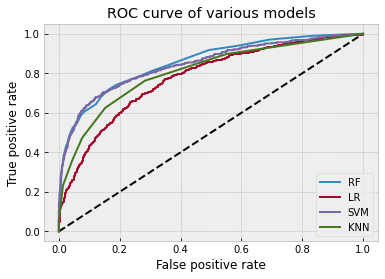

In [0]:
plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rf, trp_rf, label="RF")
plt.plot(fpr_lr, trp_lr, label="LR")
plt.plot(fpr_svm, trp_svm, label="SVM")
plt.plot(fpr_knn, trp_knn, label="KNN")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of various models')
plt.legend(loc = 'best')
plt.savefig('roc.png')
plt.show()

In [0]:
print("RF AUC score: " + str(metrics.auc(fpr_rf, trp_rf)))

RF AUC score: 0.854314947716591


In [0]:
print("SVM AUC score: " + str(metrics.auc(fpr_svm, trp_svm)))

SVM AUC score: 0.8440156539397821


In [0]:
print("logistic regression AUC score: " + str(metrics.auc(fpr_lr, trp_lr)))

logistic regression AUC score: 0.7751453248853633


In [0]:
print("KNN AUC score: " + str(metrics.auc(fpr_knn, trp_knn)))

KNN AUC score: 0.8050258580113457


Looks like our best model is random forest according to AUC score.

## best Model with recall - random forest

In [0]:
y_pred_rf = best_RF_model.predict(X_test)
recall = metrics.recall_score(y_test, y_pred_rf)
print("random forest recall: " + str(recall))

random forest recall: 0.4793713163064833


In [0]:
y_pred_svm = best_SVM_model.predict(X_test)
recall = metrics.recall_score(y_test, y_pred_svm)
print("svm recall: " + str(recall))

svm recall: 0.46954813359528486


In [0]:
y_pred_lr = best_LR_model.predict(X_test)
recall = metrics.recall_score(y_test, y_pred_lr)
print("logistic regression recall: " + str(recall))

logistic regression recall: 0.19646365422396855


In [0]:
y_pred_knn = best_KNN_model.predict(X_test)
recall = metrics.recall_score(y_test, y_pred_knn)
print("KNN recall: " + str(recall))

KNN recall: 0.35952848722986247


Looks like random forest is the best model with respect to recall as well, with a recall score of 0.48. At this point, should ask manager if this score is acceptable. If not, really need to look into more powerful models and add more features and collect more data

# feature importance detection

Suppose now manager asks why those predictions turn out to the way they did. Now I will use random forest's perk of being able to generate feature importance to answer that question. We could also use l1, l2 regularized coefficients to see feature importance, but I think using random forest is a more reliable way.

In [0]:
feature_importance_array = best_RF_model.feature_importances_
print(feature_importance_array)

[0.14982928 0.02057751 0.23106551 0.08823552 0.14642457 0.11951589
 0.0184491  0.03376532 0.15317792 0.02383227 0.01512713]


In [0]:
X.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain'],
      dtype='object')

In [0]:
for index, feature in enumerate(X.columns):
  print(feature + "'s imprtance score: " + str(feature_importance_array[index]))

CreditScore's imprtance score: 0.1498292754019354
Gender's imprtance score: 0.02057750935908157
Age's imprtance score: 0.2310655061622185
Tenure's imprtance score: 0.08823551846322243
Balance's imprtance score: 0.14642456932407386
NumOfProducts's imprtance score: 0.11951588519451901
HasCrCard's imprtance score: 0.018449095510937933
IsActiveMember's imprtance score: 0.03376531808985643
EstimatedSalary's imprtance score: 0.1531779214440335
Geography_Germany's imprtance score: 0.023832271399405622
Geography_Spain's imprtance score: 0.015127129650715818


According to our random forest, customer's age is the top influencing factors on our prediciton. The second and third important factors are salary and credit score. 

# Conclusion/Analysis



* We first downloaded and uploaded dataset from Kaggle about customer churn. Generated google drive link for our dataset.
* loaded csv into dataframe in google Colab using the download link, look at data and see its size is 10000 data points with 13 features and 1 target variable, no missing data
* did EDA on data to see distributions of categorical and numerical data. Interestingly age seems like a important factor when we look at the distribution.
* removed unnecessary columns like ID's. Did one-hot encoding on categorical columns.
* Trained various optimal models, and evaluated them using AUC and recall.
* the best model is random forest, both in AUC and recall, with AUC score of 0.854 and recall of 0.479.
* Finally confirmed that age is the most important factor in predicting if customer will churn.
* business advice to boss: older people (40 - 50 years old) are more likely to churn than (30 - 40 years old) younder people, so target on them: maybe give them some incentive credits/money to make themstay in our bank. Use random forest for prediction, as it turns out that is the best model 

